# MIDI Generation using LSTM Model

This notebook generates new MIDI files based on an example MIDI and a pre-trained LSTM model.

In [2]:
import music21
import numpy as np
from keras.models import load_model
from music21 import *
import random
import matplotlib.pyplot as plt
from IPython.display import Audio
import os
from music21 import note, chord, stream, instrument

## Configuration
Set your paths and parameters here:

In [3]:
# Paths
MODEL_PATH = "final_model.keras"
EXAMPLE_MIDI = "seed5.mid"
OUTPUT_MIDI = "generated_output.mid"

# Parameters
SEQUENCE_LENGTH = 100
N_NOTES = 200
TEMPERATURE = 1.0  # Controls randomness in generation

## Helper Functions

In [4]:
def extract_notes(file_path):
    notes = []
    try:
        midi = converter.parse(file_path)
        instruments = instrument.partitionByInstrument(midi)
        
        for part in instruments.parts:
            for element in part.flat.notes:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))
                    
        return notes, True
    except Exception as e:
        print(f"Error loading MIDI: {str(e)}")
        return [], False

In [5]:
def prepare_sequences(notes, sequence_length=SEQUENCE_LENGTH):
    pitchnames = sorted(set(notes))
    note_to_int = {note: number for number, note in enumerate(pitchnames)}
    int_to_note = {number: note for number, note in enumerate(pitchnames)}

    network_input = []
    network_output = []

    for i in range(len(notes) - sequence_length):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]

        # Map notes to integers
        try:
            input_sequence = [note_to_int[note] for note in sequence_in]
            output_note = note_to_int[sequence_out]
            network_input.append(input_sequence)
            network_output.append(output_note)
        except KeyError as e:
            print(f"Skipped invalid note: {e}")

    return np.array(network_input), np.array(network_output), len(pitchnames), pitchnames


In [22]:
def generate_notes(model, network_input, pitchnames, n_vocab, n_notes=N_NOTES, temperature=TEMPERATURE, clip_value=0.1):
    start = random.randint(0, len(network_input) - 1)
    int_to_note = {number: note for number, note in enumerate(pitchnames)}
    note_to_int = {note: number for number, note in enumerate(pitchnames)}
    
    pattern = list(network_input[start])
    prediction_output = []

    for _ in range(n_notes):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)
        
        prediction = model.predict(prediction_input, verbose=0)
        
        prediction = np.log(prediction + 1e-9) / temperature
        exp_preds = np.exp(prediction)
        exp_preds = np.clip(exp_preds, clip_value, None)
        prediction = exp_preds / np.sum(exp_preds)
        
        index = np.random.choice(len(prediction[0]), p=prediction[0])

        if index >= n_vocab or index not in int_to_note:
            print(f"Index {index} not found in int_to_note mapping. Using a random fallback note.")
            index = random.choice(list(int_to_note.keys()))
        
        result = int_to_note[index]
        prediction_output.append(result)  # Only append the note, not the tuple
        
        pattern.append(index)
        pattern = pattern[1:]
    
    return prediction_output

In [16]:
def create_midi(prediction_output, filename="output.mid"):
    """
    Create a MIDI file from the prediction output.

    Parameters:
        prediction_output: List of predicted notes or chords.
        filename: Name of the output MIDI file.

    Returns:
        music21 Stream object representing the MIDI file.
    """
    offset = 0
    output_notes = []

    for pattern in prediction_output:
        try:
            # Handle chords (e.g., "60.64.67")
            if ('.' in pattern) or pattern.isdigit():
                chord_notes = pattern.split('.')
                notes = [
                    note.Note(int(current_note), 
                              storedInstrument=instrument.Piano())
                    for current_note in chord_notes
                ]
                new_chord = chord.Chord(notes)
                new_chord.offset = offset
                output_notes.append(new_chord)
            else:
                # Handle single notes (e.g., "C4")
                new_note = note.Note(pattern)
                new_note.offset = offset
                new_note.storedInstrument = instrument.Piano()
                output_notes.append(new_note)

        except Exception as e:
            # Fallback for invalid patterns
            print(f"Error processing pattern '{pattern}': {e}. Using a fallback note.")
            fallback_note = note.Rest()  # Use a rest as a fallback
            fallback_note.offset = offset
            output_notes.append(fallback_note)

        offset += 0.5

    # Create and write the MIDI stream
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=filename)
    return midi_stream


## Load and Verify Model

In [9]:
try:
    model = load_model(MODEL_PATH)
    print("Model loaded successfully")
    model.summary()
except Exception as e:
    print(f"Error loading model: {str(e)}")

Model loaded successfully


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 100, 512)       │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100, 512)       │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 160)            │        41,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,284,898 (62.12 MB)

 Trainable params: 5,427,104 (20.70 MB)

 Non-trainable params: 3,584 (14.00 KB)

 Optimizer params: 10,854,210 (41.41 MB)

## Process Example MIDI

/usr/local/lib/python3.10/dist-packages/music21/stream/base.py:3689: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


Total notes extracted: 545
Unique notes/chords: 33


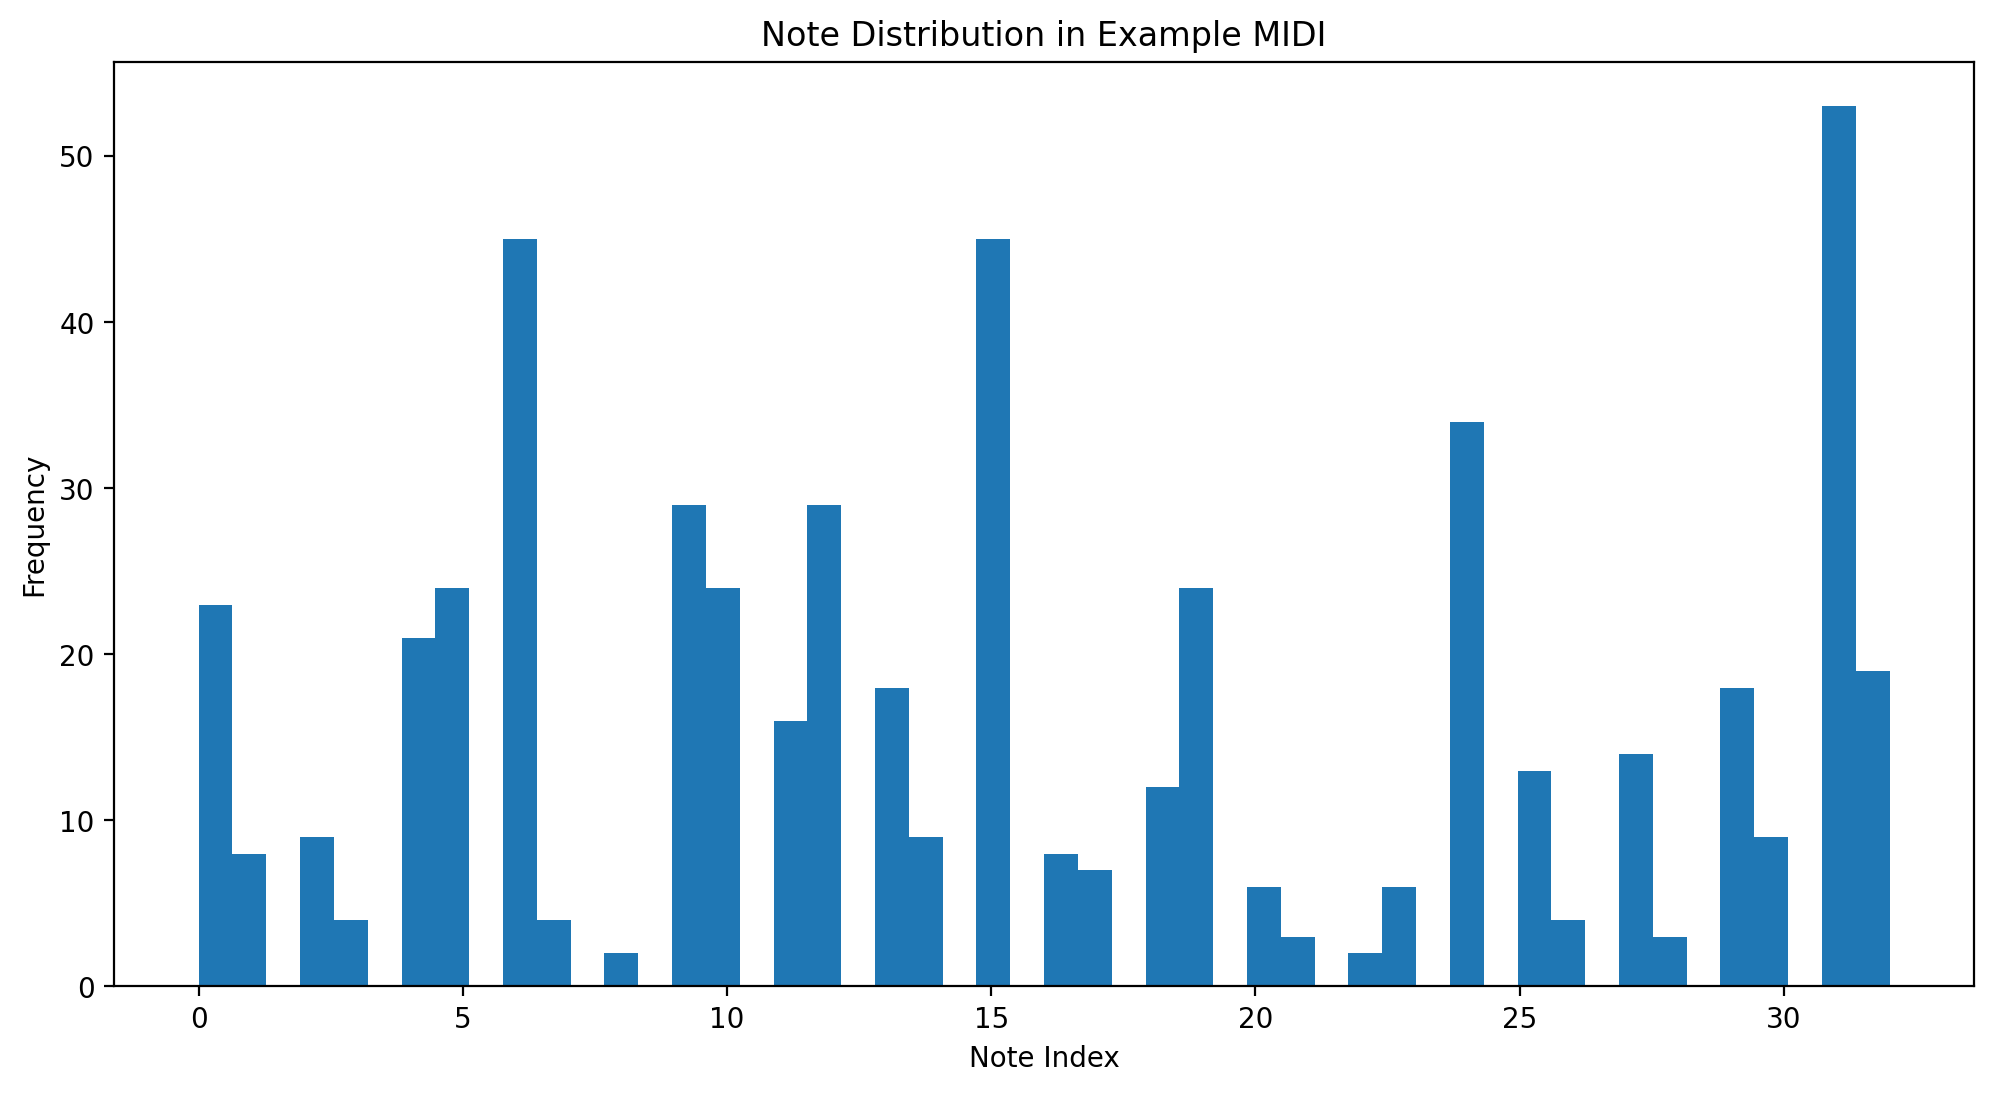

In [10]:
# Extract and analyze notes
notes, success = extract_notes(EXAMPLE_MIDI)
if success:
    print(f"Total notes extracted: {len(notes)}")
    print(f"Unique notes/chords: {len(set(notes))}")
    
    # Plot note distribution
    plt.figure(figsize=(12, 6))
    unique_notes = list(set(notes))
    plt.hist([unique_notes.index(note) for note in notes], bins=50)
    plt.title('Note Distribution in Example MIDI')
    plt.xlabel('Note Index')
    plt.ylabel('Frequency')
    plt.show()

## Generate New MIDI

In [23]:
if success:
    try:
        print("Generalizing and validating model input/output mappings...")

        # Prepare sequences
        network_input, _, n_vocab, pitchnames = prepare_sequences(notes)

        # Filter sequences to ensure alignment with vocabulary
        valid_notes = set(range(n_vocab))
        network_input = [
            [note if note in valid_notes else random.choice(list(valid_notes)) for note in sequence]
            for sequence in network_input
        ]

        print("Sequences validated and generalized.")

        # Generate new notes
        print("Generating notes...")
        prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)
        print("Note generation complete.")

        # Create MIDI file
        print("Creating MIDI file...")
        midi_stream = create_midi(prediction_output)
        print(f"Generated MIDI saved as: {OUTPUT_MIDI}")

    except Exception as e:
        print(f"An error occurred: {e}")


Generalizing and validating model input/output mappings...
Sequences validated and generalized.
Generating notes...
Index 152 not found in int_to_note mapping. Using a random fallback note.
Index 133 not found in int_to_note mapping. Using a random fallback note.
Index 69 not found in int_to_note mapping. Using a random fallback note.
Index 132 not found in int_to_note mapping. Using a random fallback note.
Index 52 not found in int_to_note mapping. Using a random fallback note.
Index 124 not found in int_to_note mapping. Using a random fallback note.
Index 112 not found in int_to_note mapping. Using a random fallback note.
Index 158 not found in int_to_note mapping. Using a random fallback note.
Index 129 not found in int_to_note mapping. Using a random fallback note.
Index 93 not found in int_to_note mapping. Using a random fallback note.
Index 99 not found in int_to_note mapping. Using a random fallback note.
Index 136 not found in int_to_note mapping. Using a random fallback note.
